# Carnatic Beat Detection: what is that beat?


### Overview

This project develops an ML/AI classifier that identifies the Carnatic beat cycle (taalam) of a mridangam solo


### Goal

Given a clip of a drum solo, identify the taalam (beat cycle) in which it is performed.

While there are 5 main taalam types that are commonly performed (and in principle thousands of possible taalams), I have restricted the scope of this project to 3 well-known and often-used taalams: aadi talam (8-beat cycle), mishra-chapu talam (7 beat cycle) and khanda-chapu talam (5-beat cycle).

### Data

In [1]:
#!pip uninstall tensorflow
#!pip install tensorflow==2.12.0

In [2]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import os
import random
import math

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import time

In [3]:
# Load the data
beatsDf1 = pd.read_csv("/content/Beats-3Class.csv")
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
108,KhandaChapu110,K,0.003480,0.007251,0.011311,0.015371,0.018852,0.021172,0.023492,0.026972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,MisraChapu-1005,M,0.001162,0.004067,0.006682,0.026438,0.029343,0.031087,0.033411,0.036897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,MisraChapu-1001,M,0.003770,0.007831,0.009571,0.011891,0.016241,0.019722,0.022042,0.025522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,KhandaChapu106,K,0.000867,0.002601,0.004335,0.006647,0.008382,0.011272,0.013006,0.015318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Aadi-1008,A,0.000873,0.003201,0.006112,0.008149,0.012515,0.016007,0.019499,0.024156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,KhandaChapu105,K,0.016016,0.018928,0.023005,0.025626,0.028829,0.031741,0.035236,0.037566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,MisraChapu-1,M,0.002025,0.006655,0.012153,0.014178,0.018229,0.021991,0.033275,0.038484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 502 entries, FileName to 500
dtypes: float64(500), object(2)
memory usage: 455.1+ KB


#### Cleanup 1:
We will set the number of numeric (time-lapse) features to be 250. Drop features with names > 250.

In [5]:
# We will drop features with names 251 -- 500
featuresToDrop = []
for nn in range(251, 501):
    featuresToDrop.append(str(nn))

In [6]:
# Drop the columns above
beatsDf1 = beatsDf1.drop(featuresToDrop, axis = 1)

In [7]:
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
74,MisraChapu-1022,M,0.000290,0.002609,0.004348,0.006667,0.008696,0.011014,0.013333,0.017681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Palghat mani iyer Aadi Taalam - 101,A,0.018044,0.022992,0.028231,0.032305,0.036088,0.039872,0.045402,0.047439,...,0.968568,0.973225,0.978754,0.983411,0.988650,0.992724,0.997090,NaN,NaN,NaN
97,KhandaChapu2027,K,0.003196,0.005811,0.008425,0.011331,0.014817,0.018884,0.022371,0.028472,...,0.859965,0.861999,0.863742,0.865485,0.867809,0.869553,0.871296,0.874782,0.877106,0.881174
38,MisraChapu-1004,M,0.003185,0.007528,0.010133,0.013028,0.016503,0.018529,0.021135,0.024899,...,0.778228,0.780544,0.783439,0.786335,0.789230,0.792415,0.794152,0.795889,0.798205,0.801390
27,Aadi-1027,A,0.000581,0.003486,0.005230,0.006682,0.009006,0.013074,0.016560,0.020046,...,0.833818,0.839338,0.842243,0.843986,0.845729,0.848925,0.851540,0.855607,0.859965,0.865776
32,Aadi-1032,A,0.000958,0.004470,0.006386,0.009898,0.013729,0.016922,0.020115,0.023308,...,0.856641,0.859834,0.863346,0.866858,0.869413,0.873244,0.875798,0.878991,0.882822,0.884738
79,KhandaChapu2009,K,0.000000,0.002328,0.004948,0.007276,0.010477,0.013679,0.016589,0.018917,...,0.750873,0.753492,0.755821,0.758149,0.761350,0.763970,0.767753,0.770955,0.773283,0.775029


In [8]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 228.5+ KB


#### Cleanup 2:
Drop rows with NaNs. These are really short clips and probably will not contain sufficient data for analysis. There is no meaningful way to fill in missing values.

In [9]:
beatsDf = beatsDf1.dropna()

In [10]:
beatsDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 199.6+ KB


In [11]:
beatsDf.sample(5)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
99,KhandaChapu2029,K,0.002023,0.005202,0.013584,0.017630,0.019942,0.025723,0.028035,0.033815,...,0.741908,0.744798,0.746821,0.750000,0.751734,0.753468,0.756936,0.759827,0.762717,0.765318
17,Aadi-1017,A,0.001445,0.004624,0.008671,0.013584,0.017052,0.019942,0.022543,0.025145,...,0.793064,0.796821,0.798555,0.800289,0.803757,0.806069,0.808671,0.811272,0.815318,0.817630
16,Aadi-1016,A,0.000869,0.004922,0.006948,0.009554,0.012160,0.015345,0.019398,0.021424,...,0.761726,0.763463,0.765489,0.767516,0.769253,0.771280,0.773306,0.775043,0.776781,0.779097
92,KhandaChapu2022,K,0.000580,0.003188,0.006667,0.008406,0.011304,0.014203,0.015942,0.017971,...,0.670145,0.673043,0.675942,0.680290,0.683768,0.685507,0.687826,0.689565,0.691304,0.693623
3,Aadi-1003,A,0.003196,0.006392,0.009587,0.028181,0.031668,0.035445,0.038640,0.049680,...,0.938698,0.941894,0.944509,0.946833,0.948286,0.949739,0.951772,0.957873,0.961650,0.964265


In [12]:
# Drop the "FileName" column
beatsDf = beatsDf.drop("FileName", axis = 1)

In [13]:
beatsDf.value_counts('Beat')

Beat
A    36
M    34
K    31
Name: count, dtype: int64

In [14]:
# For the current state of the data, we have only one 'K' beat.
#Drop it so that we have a 2-fold (binary) classification situation.
#beatsDf = beatsDf.drop(beatsDf[beatsDf.Beat == 'K'].index)

### Split data into training and test sets

In [15]:
# Data: indepndent and dependent variables
X = beatsDf.drop(['Beat'], axis = 1)

# target: the Beat type
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(beatsDf['Beat'])

In [16]:
print(y[:5])

[0 0 0 0 0]


In [17]:
y_ohe = to_categorical(y)

### ANSWER CHECK
print(y_ohe[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [18]:
rand_state = 44
# Data, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rand_state)

In [19]:
# Scale X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
y_ohe_train = to_categorical(y_train)
y_ohe_test = to_categorical(y_test)

### Optimizing the Neural Net model: number of hidden layers and number of nodes

In [21]:
def create_Seq_model(nLayers, nNodes, nClasses):
  modelName = 'Model_' + str(nLayers) + '-layers_' + str(nNodes) + '-nodes_' +  str(nClasses) + '-classes'
  model = Sequential(name = modelName)
  # Hidden layers
  for ii in range(nLayers):
    model.add(Dense(nNodes, activation="relu"))
  # The final output layer
  model.add(Dense(nClasses, activation="softmax"))
  return model


In [28]:
model_results = []

numClasses = 3
maxNumLayers = 8
numEpochs = 100
for numLay in range(2, maxNumLayers + 1):
  for numNodes in range(30, 91, 30):
    mm = create_Seq_model(nLayers = numLay, nNodes = numNodes, nClasses = numClasses)
    mm.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_mm = mm.fit(X_train_scaled, y_ohe_train, epochs = numEpochs, verbose = 0, batch_size = 3, validation_data = (X_test_scaled, y_ohe_test))

    accuracies_mm = history_mm.history['accuracy']
    validation_accuracies_mm = history_mm.history['val_accuracy']
    model_results.append({
            'Layers': numLay,
            'Nodes': numNodes,
            'fit_accuracy': accuracies_mm[-1],
            'validation_accuracy': validation_accuracies_mm[-1]
            })


In [29]:
# Dataframe out of the results
modelResultsDf = pd.DataFrame(model_results)
modelResultsDf

,Layers,Nodes,fit_accuracy,validation_accuracy
0,2,30,0.9250,0.380952
1,2,60,0.9250,0.238095
2,2,90,0.9375,0.428571
3,3,30,0.9500,0.238095
4,3,60,0.9625,0.476190
5,3,90,0.9500,0.238095
6,4,30,0.9625,0.285714
7,4,60,0.9625,0.523810
8,4,90,0.9625,0.190476
9,5,30,0.9500,0.428571


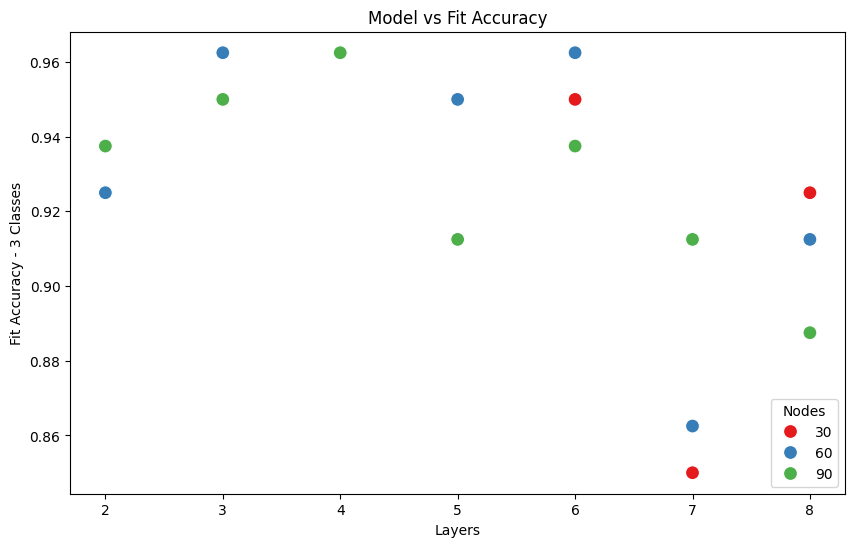

In [30]:
figg, axx = plt.subplots(figsize=(10, 6))

plt1 = sns.scatterplot(data=modelResultsDf, x='Layers', y='fit_accuracy', hue='Nodes', palette = 'Set1', s = 100)
sns.move_legend(plt1, loc='lower right')
plt1.set_title('Model vs Fit Accuracy')
plt1.set(xlabel='Layers', ylabel='Fit Accuracy - 3 Classes')
plt.show()
plt1.get_figure().savefig("/content/Images/model_fit_accuracy_scatter.png")

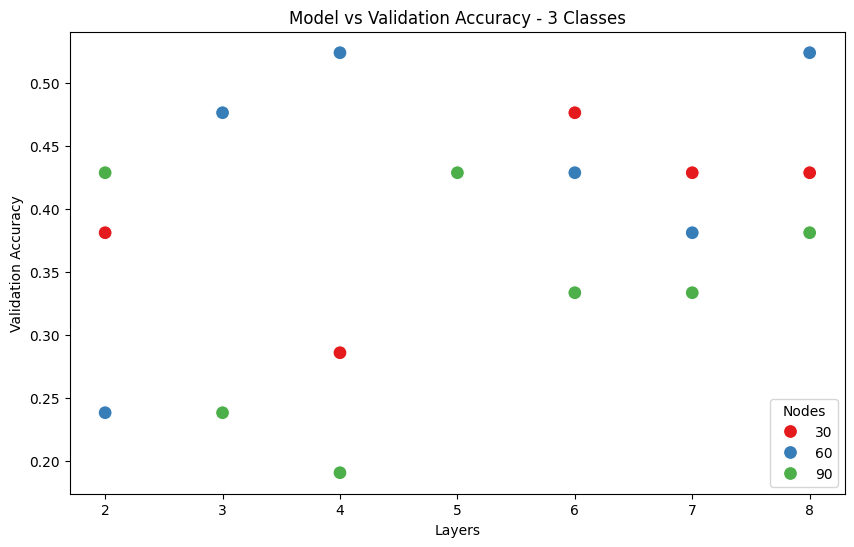

In [31]:
figg, axx = plt.subplots(figsize=(10, 6))
plt2 = sns.scatterplot(data=modelResultsDf, x='Layers', y='validation_accuracy', hue='Nodes', palette = 'Set1', s = 100)
sns.move_legend(plt2, loc='lower right')
plt2.set_title('Model vs Validation Accuracy - 3 Classes')
plt2.set(xlabel='Layers', ylabel='Validation Accuracy')
plt.show()
plt2.get_figure().savefig("/content/Images/model_valid_accuracy_scatter.png")

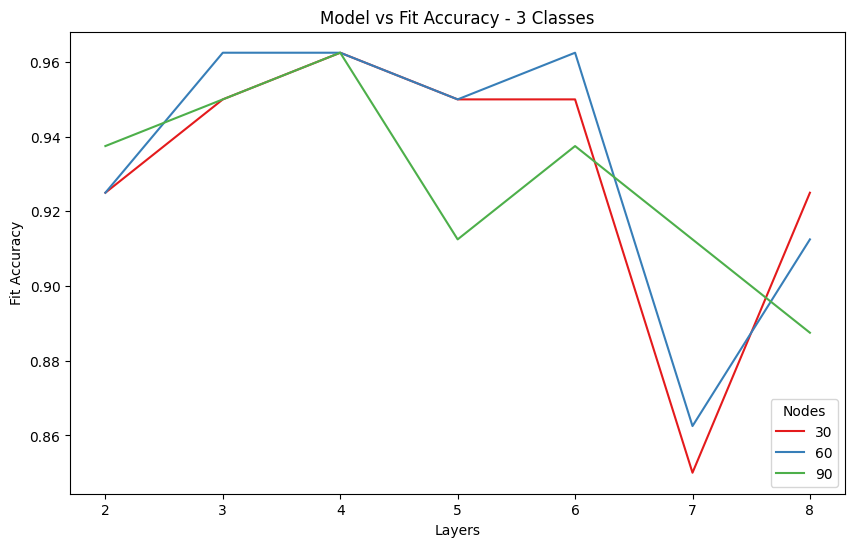

In [32]:
figg, axx = plt.subplots(figsize=(10, 6))
plt3 = sns.lineplot(data=modelResultsDf, x='Layers', y='fit_accuracy', hue='Nodes', palette = 'Set1')
sns.move_legend(plt3, loc='lower right')
plt3.set_title('Model vs Fit Accuracy - 3 Classes')
plt3.set(xlabel='Layers', ylabel='Fit Accuracy')
plt.show()
plt3.get_figure().savefig("/content/Images/model_fit_accuracy_line.png")

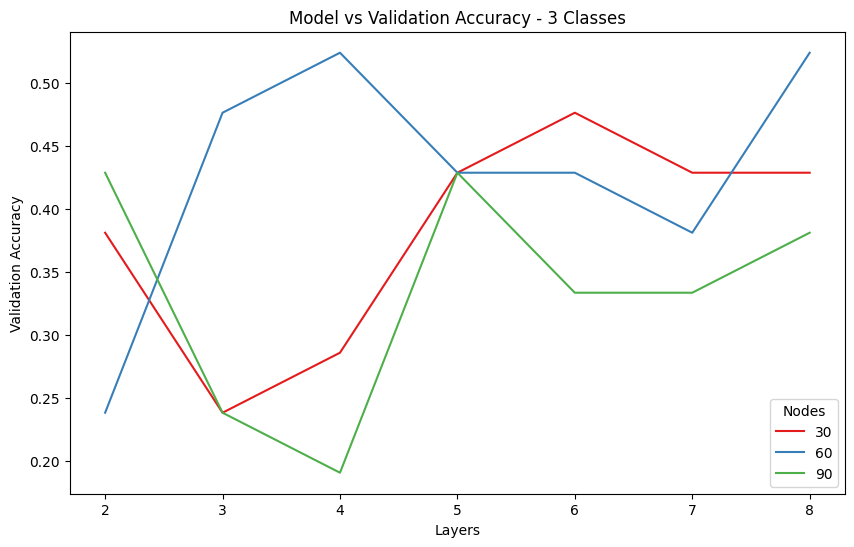

In [34]:
figg, axx = plt.subplots(figsize=(10, 6))
plt4 = sns.lineplot(data=modelResultsDf, x='Layers', y='validation_accuracy', hue='Nodes', palette = 'Set1')
sns.move_legend(plt4, loc='lower right')
plt4.set_title('Model vs Validation Accuracy - 3 Classes')
plt4.set(xlabel='Layers', ylabel='Validation Accuracy')
plt.show()
plt4.get_figure().savefig("/content/Images/model_valid_accuracy_line.png")

### Evaluation

#### Model Accuracy
Some models fared better than random chance (0.33) but none were very impressive. The best validation scores are close to 0.6 (almost twice as good as random chance).  The simplest model with this score is (number of layers = 7, number of nodes = 60). More data is needed to make definitive conclusions about model accuracy.

#### Caveat
The above analysis was done with a very small dataset! The results might change as more data is generated and brought into the analysis.